In [1]:
# load required libraries
library(readr)
library(magrittr)
library(zoo)
library(lubridate)
library(ggplot2)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
# load tidyverse
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ lubridate::date()        masks base::date()
✖ tidyr::extract()         masks magrittr::extract()
✖ dplyr::filter()          masks stats::filter()
✖ lubridate::intersect()   masks base::intersect()
✖ dplyr::lag()             masks stats::lag()
✖ purrr::set_names()       masks magrittr::set_names()
✖ lubridate::setdiff()     masks base::setdiff()
✖ lubridate::union()       masks base::union()



In [3]:
# load the Covid-19 data
covid_df <- "WHO-COVID-19-global-data.csv" %>% 
    read_csv()

Parsed with column specification:
cols(
  Date_reported = col_date(format = ""),
  Country_code = col_character(),
  Country = col_character(),
  WHO_region = col_character(),
  New_cases = col_double(),
  Cumulative_cases = col_double(),
  New_deaths = col_double(),
  Cumulative_deaths = col_double()
)



In [4]:
# rename the Date column to a shorter name
covid_df <- covid_df %>% 
  rename(Date = Date_reported)

In [5]:
# take a look the dataframe
covid_df %>%
  head()

Date,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
2020-01-07,AF,Afghanistan,EMRO,0,0,0,0
2020-01-08,AF,Afghanistan,EMRO,0,0,0,0


In [6]:
# overview the dataframe structure
covid_df %>% 
  str()

tibble [65,218 × 8] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Date             : Date[1:65218], format: "2020-01-03" "2020-01-04" ...
 $ Country_code     : chr [1:65218] "AF" "AF" "AF" "AF" ...
 $ Country          : chr [1:65218] "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ WHO_region       : chr [1:65218] "EMRO" "EMRO" "EMRO" "EMRO" ...
 $ New_cases        : num [1:65218] 0 0 0 0 0 0 0 0 0 0 ...
 $ Cumulative_cases : num [1:65218] 0 0 0 0 0 0 0 0 0 0 ...
 $ New_deaths       : num [1:65218] 0 0 0 0 0 0 0 0 0 0 ...
 $ Cumulative_deaths: num [1:65218] 0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, "spec")=
  .. cols(
  ..   Date_reported = col_date(format = ""),
  ..   Country_code = col_character(),
  ..   Country = col_character(),
  ..   WHO_region = col_character(),
  ..   New_cases = col_double(),
  ..   Cumulative_cases = col_double(),
  ..   New_deaths = col_double(),
  ..   Cumulative_deaths = col_double()
  .. )


In [7]:
# count how many dates and countries are recorded in this dataset
covid_df$Date %>% unique() %>% length()
covid_df$Country %>% unique() %>% length()

[1] 278

[1] 235

In [8]:
# create a function to translate WHO region names
translate_WHO <- function(region){
    if (region %in% "AMRO"){
        region = "Americas"
    }
    else if (region %in% "SEARO"){
        region = "South-East Asia"
    }
    else if (region %in% "EURO"){
        region = "European"
    }
    else if (region %in% "AFRO"){
        region = "African"
    }
    else if (region %in% "WPRO"){
        region = "Western Pacific"
    }
    else if (region %in% "EMRO"){
        region = "Eastern Mediterranean"
    }
    else
        region = region
}
covid_df$WHO_region <- sapply(covid_df$WHO_region, translate_WHO)

In [33]:
# translate the WHO regions name
# covid_df <- covid_df %>%
    # mutate(WHO_region = ifelse(WHO_region == "AMRO", "Americas", 
                               #ifelse(WHO_region == "SEARO", "South-East Asia",
                                      # ifelse(WHO_region == "EURO", "European", 
                                             # ifelse(WHO_region == "AFRO", "African", 
                                                    # ifelse(WHO_region == "WPRO", "Western Pacific", 
                                                           # ifelse(WHO_region == "EMRO", "Eastern Mediterranean", 
                                                                  # WHO_region
                                                                 # )
                                                          # )
                                                   # )
                                            # )
                                     # )
                              # )
          # )

The above is our previous code showed in presentation, which we realized the problem was actually computational expensive. Ifelse is good at dealing with vectors, each ifelse command will go through a whole vector of "WHO_region". There were 6 of them, which means the "WHO_region" will go through it 6 times, rather than "map" the vector through the created "translate_WHO" function to check on each row, and the vector only go through it once.

In [34]:
# reshape the covid dataframe to a long table with all the numeric values in one column
covid_long <- covid_df %>% pivot_longer(cols=c(New_cases, Cumulative_cases, New_deaths, Cumulative_deaths), 
                              names_to = "Stat", 
                              values_to = "Value")

In [10]:
# load library for animate plot and saving them
#install.packages("gifski")
library(gganimate)
library(gifski)

In [982]:
# plot the average worldwide daily Covid-19 status over months
Covid_daily <- covid_long %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth, Stat) %>%
  summarise(mean_stat = mean(Value)) %>%
  ggplot(aes(x = yr_mth, y = mean_stat, colour = Stat)) +
  geom_line(size = 1) + 
  theme_bw() + 
  ggtitle("Average Worldwide Daily Covid-19 Stats over Months") +
  labs(x = "Month", y = "Individuals") +
  guides(colour=guide_legend(title="Covid-19 stats")) +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  theme(axis.text.x = element_text(size = 10, angle = 0),
        plot.title = element_text(hjust = 0.5)) +
  transition_reveal(yr_mth)
  animate(Covid_daily, nframes = 50, renderer = gifski_renderer("Covid_daily.gif"))

`summarise()` regrouping output by 'yr_mth' (override with `.groups` argument)


Rendering [>-------------------------------------------] at 1.3 fps ~ eta: 39s

Rendering [=>------------------------------------------] at 1.4 fps ~ eta: 35s

Rendering [==>-----------------------------------------] at 1.4 fps ~ eta: 34s

Rendering [===>----------------------------------------] at 1.5 fps ~ eta: 31s

Rendering [===>----------------------------------------] at 1.6 fps ~ eta: 29s

Rendering [====>---------------------------------------] at 1.6 fps ~ eta: 27s

Rendering [=====>--------------------------------------] at 1.6 fps ~ eta: 27s

Rendering [======>-------------------------------------] at 1.6 fps ~ eta: 26s

Rendering [=======>------------------------------------] at 1.6 fps ~ eta: 26s

Rendering [========>-----------------------------------] at 1.5 fps ~ eta: 26s

Rendering [=========>----------------------------------] at 1.5 fps ~ eta: 25s

Rendering [==========>-----------------

In [983]:
# plot the average WHO region daily Covid-19 status over months
Covid_daily_WHO <- covid_long %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth, WHO_region, Stat) %>%
  summarise(mean_stat = mean(Value)) %>%
  ggplot(aes(x = yr_mth, y = mean_stat, colour = Stat)) +
  geom_line(size = 1) + 
  theme_bw() + 
  ggtitle("Average WHO Region Daily Covid-19 Stats over Months") +
  labs(x = "Month", y = "Individuals") +
  guides(colour=guide_legend(title="Covid-19 stats")) +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  theme(axis.text.x = element_text(size = 10, angle = 90), plot.title = element_text(hjust = 0.5)) +
  facet_wrap( ~ WHO_region, ncol = 3) +
  transition_reveal(yr_mth) 
animate(Covid_daily_WHO, nframes = 50, renderer = gifski_renderer("Covid_daily_WHO.gif"))

`summarise()` regrouping output by 'yr_mth', 'WHO_region' (override with `.groups` argument)


Rendering [>------------------------------------------] at 0.87 fps ~ eta:  1m

Rendering [=>-----------------------------------------] at 0.62 fps ~ eta:  1m

Rendering [==>----------------------------------------] at 0.64 fps ~ eta:  1m

Rendering [==>----------------------------------------] at 0.69 fps ~ eta:  1m

Rendering [===>---------------------------------------] at 0.72 fps ~ eta:  1m

Rendering [====>--------------------------------------] at 0.76 fps ~ eta:  1m

Rendering [=====>-------------------------------------] at 0.79 fps ~ eta:  1m

Rendering [======>------------------------------------] at 0.81 fps ~ eta:  1m

Rendering [=======>-----------------------------------] at 0.83 fps ~ eta: 49s

Rendering [========>----------------------------------] at 0.85 fps ~ eta: 47s

Rendering [========>----------------------------------] at 0.86 fps ~ eta: 46s

Rendering [=========>----

In [984]:
# plot the average WHO region daily Covid-19 status by category over months
Covid_daily_category <- covid_long %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth, Stat, WHO_region) %>%
  summarise(mean_stat = mean(Value)) %>%
  ggplot(aes(x = yr_mth, y = mean_stat, colour = WHO_region)) +
  geom_line(size = 1) + 
  theme_bw() + 
  ggtitle("Average WHO Region Daily Covid-19 Stats by Category over Months") +
  labs(x = "Month", y = "Individuals") +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  theme(axis.text.x = element_text(size = 10, angle = 0), plot.title = element_text(hjust = 0.5)) +
  facet_wrap( ~ Stat, ncol = 2) +
  transition_reveal(yr_mth)
animate(Covid_daily_category, nframes = 50, renderer = gifski_renderer("Covid_daily_category.gif"))

`summarise()` regrouping output by 'yr_mth', 'Stat' (override with `.groups` argument)


Rendering [>-------------------------------------------] at 1.3 fps ~ eta: 38s

Rendering [=>------------------------------------------] at 1.3 fps ~ eta: 37s

Rendering [==>-----------------------------------------] at 1.3 fps ~ eta: 36s

Rendering [===>----------------------------------------] at 1.3 fps ~ eta: 36s

Rendering [===>----------------------------------------] at 1.3 fps ~ eta: 35s

Rendering [====>---------------------------------------] at 1.3 fps ~ eta: 34s

Rendering [=====>--------------------------------------] at 1.3 fps ~ eta: 33s

Rendering [======>-------------------------------------] at 1.3 fps ~ eta: 32s

Rendering [=======>------------------------------------] at 1.3 fps ~ eta: 31s

Rendering [========>-----------------------------------] at 1.3 fps ~ eta: 31s

Rendering [=========>----------------------------------] at 1.3 fps ~ eta: 30s

Rendering [==========>---------

In [985]:
# plot the average WHO region daily Covid-19 new cases over months
Covid_daily_newCase <- covid_long %>%
  filter(Stat == "New_cases") %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth, WHO_region) %>%
  summarise(mean_stat = mean(Value)) %>%
  ggplot(aes(x = yr_mth, y = mean_stat, colour = WHO_region)) +
  geom_line(size = 1) + 
  theme_bw() + 
  ggtitle("Average WHO Region Daily Covid-19 New Cases over Months") +
  labs(x = "Month", y = "Individuals") +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  theme(axis.text.x = element_text(size = 10, angle = 0), plot.title = element_text(hjust = 0.5)) +
  transition_reveal(yr_mth)
animate(Covid_daily_newCase, nframes = 50, renderer = gifski_renderer("Covid_daily_newCase.gif"))

`summarise()` regrouping output by 'yr_mth' (override with `.groups` argument)


Rendering [>-------------------------------------------] at 1.8 fps ~ eta: 27s

Rendering [=>------------------------------------------] at 1.9 fps ~ eta: 25s

Rendering [==>-------------------------------------------] at 2 fps ~ eta: 24s

Rendering [===>------------------------------------------] at 2 fps ~ eta: 23s

Rendering [====>-----------------------------------------] at 2 fps ~ eta: 23s

Rendering [=====>----------------------------------------] at 2 fps ~ eta: 23s

Rendering [=====>--------------------------------------] at 1.9 fps ~ eta: 22s

Rendering [======>-------------------------------------] at 1.9 fps ~ eta: 22s

Rendering [=======>------------------------------------] at 1.9 fps ~ eta: 22s

Rendering [========>-----------------------------------] at 1.9 fps ~ eta: 21s

Rendering [=========>----------------------------------] at 1.9 fps ~ eta: 21s

Rendering [==========>-----------------

In [986]:
# plot the average South-East Asia daily Covid-19 new cases over months
Covid_daily_newCase_SEARO <- covid_long %>%
  filter(WHO_region == "South-East Asia" & Stat == "New_cases") %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth, Country) %>%
  summarise(mean_stat = mean(Value)) %>%
  ggplot(aes(x = yr_mth, y = mean_stat, colour = Country)) +
  geom_line(size = 1) + 
  theme_bw() + 
  ggtitle("Average South-East Asia Daily Covid-19 New Cases over Months") +
  labs(x = "Month", y = "Individuals") +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  theme(axis.text.x = element_text(size = 10, angle = 0), plot.title = element_text(hjust = 0.5)) +
  transition_reveal(yr_mth)
animate(Covid_daily_newCase_SEARO, nframes = 50, renderer = gifski_renderer("Covid_daily_newCase_SEARO.gif"))

`summarise()` regrouping output by 'yr_mth' (override with `.groups` argument)


Rendering [>-------------------------------------------] at 1.4 fps ~ eta: 34s

Rendering [=>------------------------------------------] at 1.4 fps ~ eta: 33s

Rendering [==>-----------------------------------------] at 1.2 fps ~ eta: 39s

Rendering [===>----------------------------------------] at 1.1 fps ~ eta: 40s

Rendering [===>----------------------------------------] at 1.2 fps ~ eta: 37s

Rendering [====>---------------------------------------] at 1.2 fps ~ eta: 35s

Rendering [=====>--------------------------------------] at 1.2 fps ~ eta: 35s

Rendering [======>-------------------------------------] at 1.2 fps ~ eta: 35s

Rendering [=======>------------------------------------] at 1.2 fps ~ eta: 36s

Rendering [========>-----------------------------------] at 1.1 fps ~ eta: 36s

Rendering [=========>----------------------------------] at 1.1 fps ~ eta: 35s

Rendering [==========>-----------------

In [925]:
# plot the average Americas daily Covid-19 new cases more than 4000 over months
Covid_daily_newCase_AMRO <- covid_long %>%
  filter(WHO_region == "Americas" & Stat == "New_cases" & Value > 4000) %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth, Country) %>%
  summarise(mean_stat = mean(Value)) %>%
  ggplot(aes(x = yr_mth, y = mean_stat, colour = Country)) +
  geom_line(size = 1) + 
  theme_bw() + 
  ggtitle("Average Americas Daily Covid-19 New Cases over Months") +
  labs(x = "Month", y = "Individuals") +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  theme(axis.text.x = element_text(size = 10, angle = 0), plot.title = element_text(hjust = 0.5)) +
  transition_reveal(yr_mth)
animate(Covid_daily_newCase_AMRO, nframes = 50, renderer = gifski_renderer("Covid_daily_newCase_AMRO.gif"))

`summarise()` regrouping output by 'yr_mth' (override with `.groups` argument)


Rendering [>---------------------------------------------] at 2 fps ~ eta: 25s

Rendering [=>------------------------------------------] at 1.7 fps ~ eta: 28s

Rendering [==>-----------------------------------------] at 1.6 fps ~ eta: 29s

Rendering [===>----------------------------------------] at 1.6 fps ~ eta: 29s

Rendering [===>----------------------------------------] at 1.6 fps ~ eta: 28s

Rendering [====>---------------------------------------] at 1.6 fps ~ eta: 28s

Rendering [=====>--------------------------------------] at 1.6 fps ~ eta: 27s

Rendering [======>-------------------------------------] at 1.6 fps ~ eta: 26s

Rendering [=======>------------------------------------] at 1.6 fps ~ eta: 25s

Rendering [========>-----------------------------------] at 1.6 fps ~ eta: 25s

Rendering [=========>----------------------------------] at 1.6 fps ~ eta: 24s

Rendering [==========>-----------------

In [987]:
# plot the average African daily Covid-19 new cases more than 800 over months
Covid_daily_newCase_AFRO <- covid_long %>%
  filter(WHO_region == "African" & Stat == "New_cases" & Value > 800) %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth, Country) %>%
  summarise(mean_stat = mean(Value)) %>%
  ggplot(aes(x = yr_mth, y = mean_stat, colour = Country)) +
  geom_line(size = 1) + 
  theme_bw() + 
  ggtitle("Average African Daily Covid-19 New Cases over Months") +
  labs(x = "Month", y = "Individuals") +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  theme(axis.text.x = element_text(size = 10, angle = 0), plot.title = element_text(hjust = 0.5)) +
  transition_reveal(yr_mth)
animate(Covid_daily_newCase_AFRO, nframes = 50, renderer = gifski_renderer("Covid_daily_newCase_AFRO.gif"))

`summarise()` regrouping output by 'yr_mth' (override with `.groups` argument)


Rendering [>-------------------------------------------] at 1.9 fps ~ eta: 25s

Rendering [=>------------------------------------------] at 2.1 fps ~ eta: 23s

Rendering [==>-----------------------------------------] at 2.1 fps ~ eta: 22s

Rendering [===>----------------------------------------] at 2.2 fps ~ eta: 21s

Rendering [====>---------------------------------------] at 2.2 fps ~ eta: 20s

Rendering [=====>--------------------------------------] at 2.2 fps ~ eta: 19s

Rendering [======>-------------------------------------] at 2.2 fps ~ eta: 19s

Rendering [=======>------------------------------------] at 2.2 fps ~ eta: 18s

Rendering [========>-----------------------------------] at 2.1 fps ~ eta: 19s

Rendering [=========>------------------------------------] at 2 fps ~ eta: 20s

Rendering [==========>-----------------------------------] at 2 fps ~ eta: 19s

Rendering [===========>----------------

In [988]:
# plot the average Eastern Mediterranean daily Covid-19 new cases more than 2000 over months
Covid_daily_newCase_EMRO <- covid_long %>%
  filter(WHO_region == "Eastern Mediterranean" & Stat == "New_cases" & Value > 2000) %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth, Country) %>%
  summarise(mean_stat = mean(Value)) %>%
  ggplot(aes(x = yr_mth, y = mean_stat, colour = Country)) +
  geom_line(size = 1) + 
  theme_bw() + 
  ggtitle("Average Eastern Mediterranean Daily Covid-19 New Cases over Months") +
  labs(x = "Month", y = "Individuals") +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  theme(axis.text.x = element_text(size = 10, angle = 0), plot.title = element_text(hjust = 0.5)) +
  transition_reveal(yr_mth)
animate(Covid_daily_newCase_EMRO, nframes = 50, renderer = gifski_renderer("Covid_daily_newCase_EMRO.gif"))

`summarise()` regrouping output by 'yr_mth' (override with `.groups` argument)


Rendering [>-------------------------------------------] at 1.8 fps ~ eta: 27s

Rendering [=>------------------------------------------] at 1.8 fps ~ eta: 26s

Rendering [==>-----------------------------------------] at 1.9 fps ~ eta: 25s

Rendering [===>----------------------------------------] at 1.9 fps ~ eta: 24s

Rendering [===>----------------------------------------] at 1.9 fps ~ eta: 23s

Rendering [====>---------------------------------------] at 1.9 fps ~ eta: 23s

Rendering [=====>----------------------------------------] at 2 fps ~ eta: 22s

Rendering [======>---------------------------------------] at 2 fps ~ eta: 21s

Rendering [=======>--------------------------------------] at 2 fps ~ eta: 21s

Rendering [========>-------------------------------------] at 2 fps ~ eta: 20s

Rendering [=========>------------------------------------] at 2 fps ~ eta: 20s

Rendering [==========>-----------------

In [989]:
# plot the average European daily Covid-19 new cases more than 5000 over months
Covid_daily_newCase_EURO <- covid_long %>%
  filter(WHO_region == "European" & Stat == "New_cases" & Value > 5000) %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth, Country) %>%
  summarise(mean_stat = mean(Value)) %>%
  ggplot(aes(x = yr_mth, y = mean_stat, colour = Country)) +
  geom_line(size = 1) + 
  theme_bw() + 
  ggtitle("Average European Daily Covid-19 New Cases over Month") +
  labs(x = "Month", y = "Individuals") +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  theme(axis.text.x = element_text(size = 10, angle = 0), plot.title = element_text(hjust = 0.5)) +
  transition_reveal(yr_mth)
animate(Covid_daily_newCase_EURO, nframes = 50, renderer = gifski_renderer("Covid_daily_newCase_EURO.gif"))

`summarise()` regrouping output by 'yr_mth' (override with `.groups` argument)


Rendering [>-------------------------------------------] at 1.3 fps ~ eta: 38s

Rendering [=>------------------------------------------] at 1.1 fps ~ eta: 42s

Rendering [==>-----------------------------------------] at 1.2 fps ~ eta: 40s

Rendering [===>----------------------------------------] at 1.3 fps ~ eta: 36s

Rendering [===>----------------------------------------] at 1.4 fps ~ eta: 33s

Rendering [====>---------------------------------------] at 1.4 fps ~ eta: 31s

Rendering [=====>--------------------------------------] at 1.5 fps ~ eta: 29s

Rendering [======>-------------------------------------] at 1.4 fps ~ eta: 30s

Rendering [=======>------------------------------------] at 1.4 fps ~ eta: 28s

Rendering [========>-----------------------------------] at 1.5 fps ~ eta: 27s

Rendering [=========>----------------------------------] at 1.4 fps ~ eta: 27s

Rendering [==========>-----------------

In [990]:
# plot the average Western Pacific and Other daily Covid-19 new cases more than 500 over months
Covid_daily_newCase_WPRO <- covid_long %>%
  filter((WHO_region == "Western Pacific" | WHO_region == "Other") & Stat == "New_cases" & Value > 500) %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth, Country) %>%
  summarise(mean_stat = mean(Value)) %>%
  ggplot(aes(x = yr_mth, y = mean_stat, colour = Country)) +
  geom_line(size = 1) + 
  theme_bw() + 
  ggtitle("Average Western Pacific and Other Daily Covid-19 New Cases over Month") +
  labs(x = "Month", y = "Individuals") +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  theme(axis.text.x = element_text(size = 10, angle = 0), plot.title = element_text(hjust = 0.5)) +
  transition_reveal(yr_mth)
animate(Covid_daily_newCase_WPRO, nframes = 50, renderer = gifski_renderer("Covid_daily_newCase_WPRO.gif"))

`summarise()` regrouping output by 'yr_mth' (override with `.groups` argument)


Rendering [>-------------------------------------------] at 2.3 fps ~ eta: 21s

Rendering [=>--------------------------------------------] at 2 fps ~ eta: 24s

Rendering [==>-----------------------------------------] at 1.8 fps ~ eta: 25s

Rendering [===>----------------------------------------] at 1.8 fps ~ eta: 25s

Rendering [====>---------------------------------------] at 1.8 fps ~ eta: 24s

Rendering [=====>--------------------------------------] at 1.8 fps ~ eta: 24s

Rendering [======>-------------------------------------] at 1.8 fps ~ eta: 24s

Rendering [=======>------------------------------------] at 1.8 fps ~ eta: 23s

Rendering [========>-----------------------------------] at 1.8 fps ~ eta: 22s

Rendering [=========>----------------------------------] at 1.7 fps ~ eta: 23s

Rendering [==========>---------------------------------] at 1.8 fps ~ eta: 22s

Rendering [==========>-----------------

In [299]:
country_list = list("Argentina", "Brazil", "Chile", "Colombia", "India", "Iraq", "Iran (Islamic Republic of)", 
                    "Mexico", "Peru", "Russian Federation", "South Africa", "United States of America")

`summarise()` regrouping output by 'yr_mth' (override with `.groups` argument)



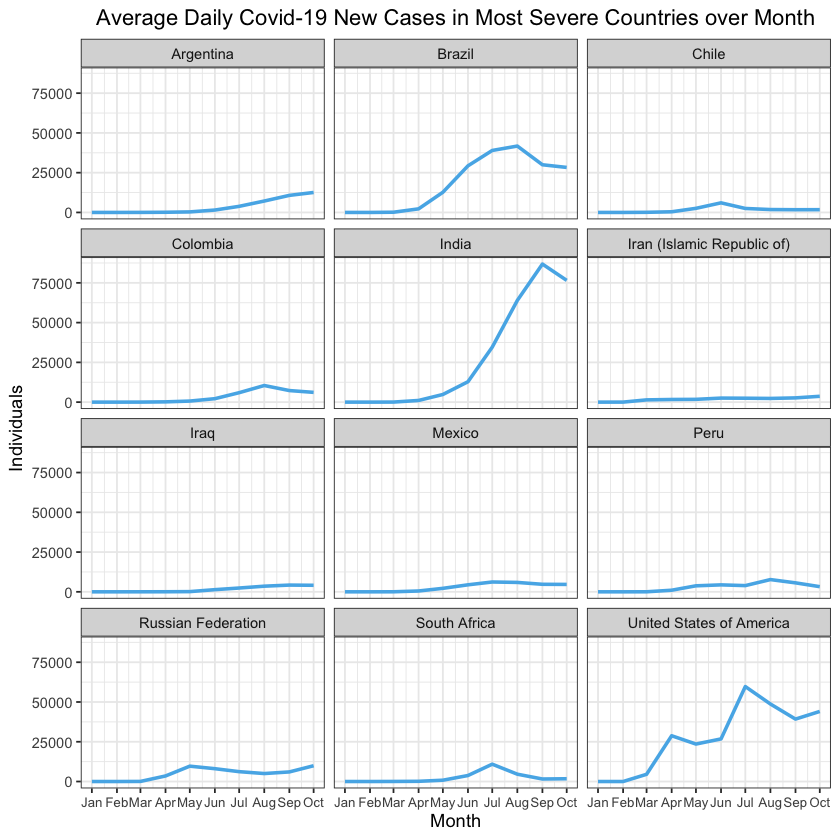

In [930]:
# plot the average daily Covid-19 new cases in most severe countries over months
covid_long %>%
  filter(Country %in% country_list & Stat == "New_cases") %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth, Country) %>%
  summarise(mean_stat = mean(Value)) %>%
  ggplot(aes(x = yr_mth, y = mean_stat)) +
  geom_line(color = "#56B4E9", size = 1) + 
  theme_bw() + 
  ggtitle("Average Daily Covid-19 New Cases in Most Severe Countries over Month") +
  labs(x = "Month", y = "Individuals") +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  facet_wrap( ~ Country, ncol = 3) +
  theme(axis.text.x = element_text(size = 8, angle = 0), plot.title = element_text(hjust = 0.5))

`summarise()` regrouping output by 'yr_mth' (override with `.groups` argument)



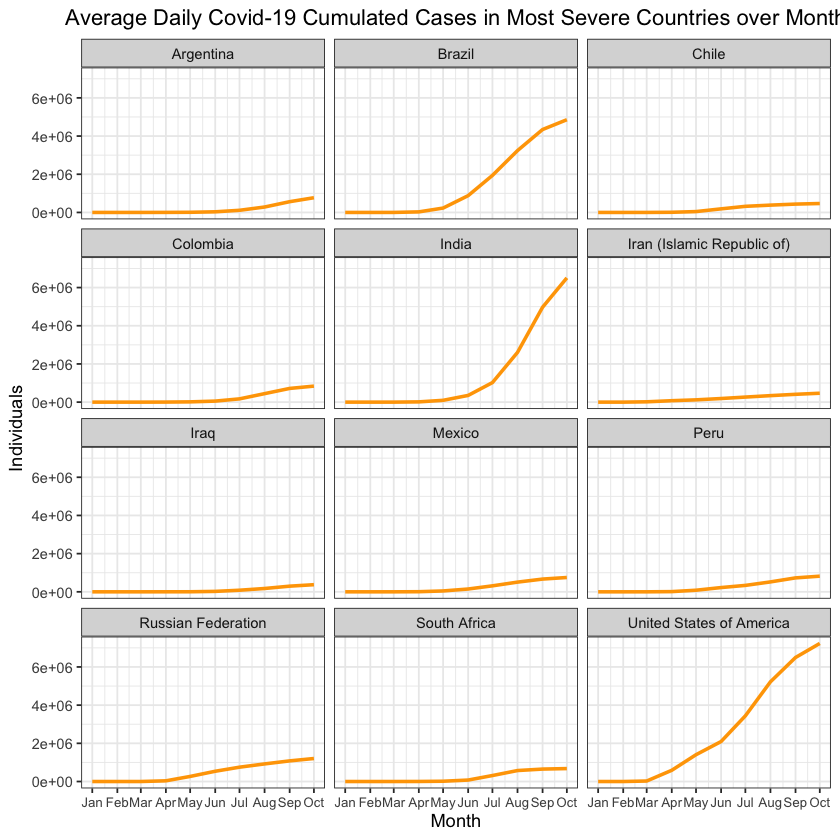

In [932]:
# plot the average daily Covid-19 cumulated cases in most severe countries over months
covid_long %>%
  filter(Country %in% country_list & Stat == "Cumulative_cases") %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth, Country) %>%
  summarise(mean_stat = mean(Value)) %>%
  ggplot(aes(x = yr_mth, y = mean_stat)) +
  geom_line(color = "orange", size = 1) + 
  theme_bw() + 
  ggtitle("Average Daily Covid-19 Cumulated Cases in Most Severe Countries over Month") +
  labs(x = "Month", y = "Individuals") +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  facet_wrap( ~ Country, ncol = 3) +
  theme(axis.text.x = element_text(size = 8, angle = 0), plot.title = element_text(hjust = 0.5))

`summarise()` regrouping output by 'yr_mth' (override with `.groups` argument)



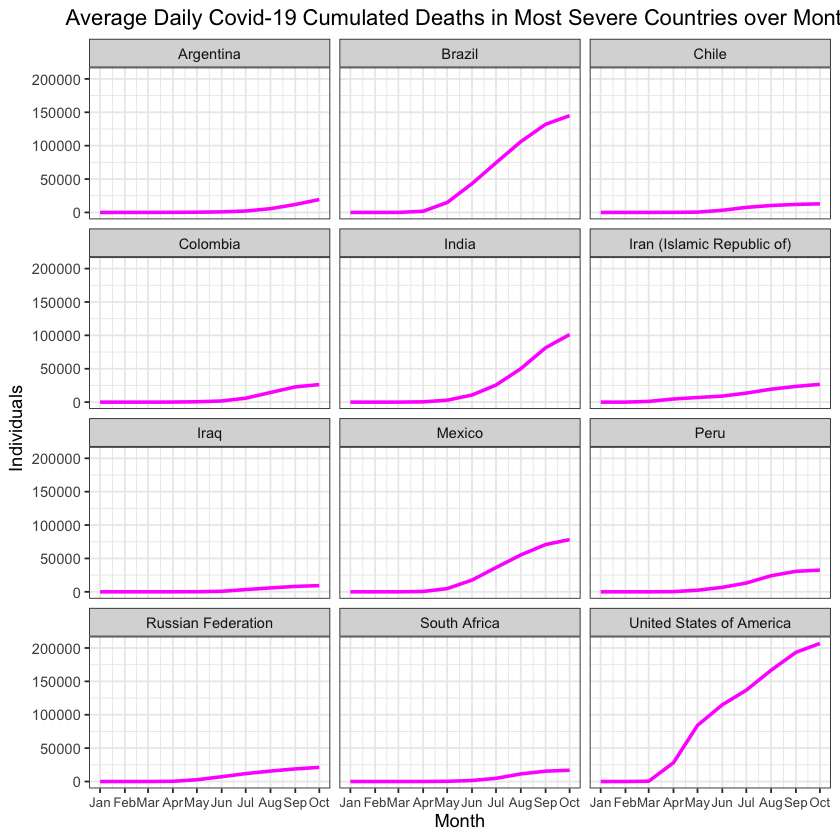

In [933]:
# plot the average daily Covid-19 cumulated deaths in most severe countries over months
covid_long %>%
  filter(Country %in% country_list & Stat == "Cumulative_deaths") %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth, Country) %>%
  summarise(mean_stat = mean(Value)) %>%
  ggplot(aes(x = yr_mth, y = mean_stat)) +
  geom_line(color = "magenta", size = 1) + 
  theme_bw() + 
  ggtitle("Average Daily Covid-19 Cumulated Deaths in Most Severe Countries over Month") +
  labs(x = "Month", y = "Individuals") +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  facet_wrap( ~ Country, ncol = 3) +
  theme(axis.text.x = element_text(size = 8, angle = 0), plot.title = element_text(hjust = 0.5))

In [1321]:
# reshape covid dataframe to a different shape with two value columns and ready for plotting
covid_semiLong <- covid_df %>% 
  pivot_longer(cols=c(Cumulative_cases, Cumulative_deaths),
               names_to = "Cumulative_stat", 
               values_to = "Cumulative_value") %>%
  pivot_longer(cols=c(New_cases, New_deaths),
               names_to = "New_stat", 
               values_to = "New_value")

`summarise()` ungrouping output (override with `.groups` argument)



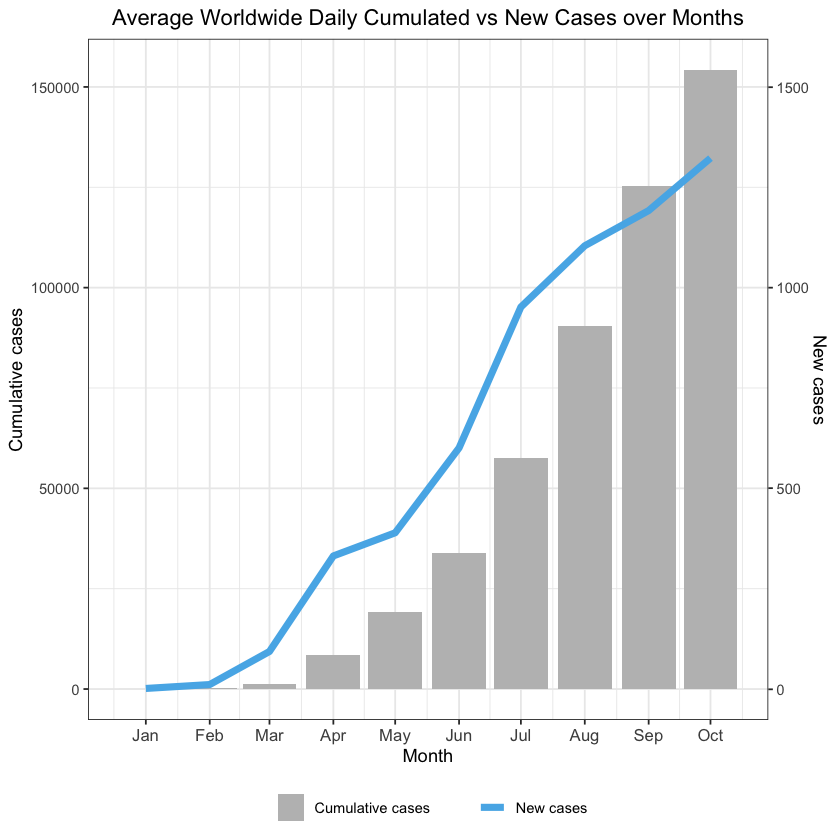

In [975]:
# plot average worldwide daily cumulated vs new cases over months
covid_semiLong %>%
  filter(Cumulative_stat == "Cumulative_cases" & New_stat == "New_cases") %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth) %>%
  summarise(mean_cumulativeStat = mean(Cumulative_value), mean_newStat = mean(New_value)) %>%
  ggplot() +
  geom_bar(mapping = aes(x = yr_mth, y = mean_cumulativeStat, fill = "Cumulative cases"), stat = "identity") +
  geom_line(mapping = aes(x = yr_mth, y = mean_newStat * 100, color = "New cases"), size = 2) +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  scale_y_continuous(name = "Cumulative cases", 
  sec.axis = sec_axis(~./100, name = "New cases")) + 
  scale_fill_manual(name = NULL, values = c("Cumulative cases" = "grey")) +
  scale_color_manual(name = NULL, values = c("New cases" = "#56B4E9")) +
  labs(x = "Month") +
  ggtitle("Average Worldwide Daily Cumulated VS New Cases over Months") +
  theme_bw() +
  theme(axis.text.x = element_text(size = 10, angle = 0), 
        legend.position = "bottom",
        plot.title = element_text(hjust = 0.5))

`summarise()` ungrouping output (override with `.groups` argument)



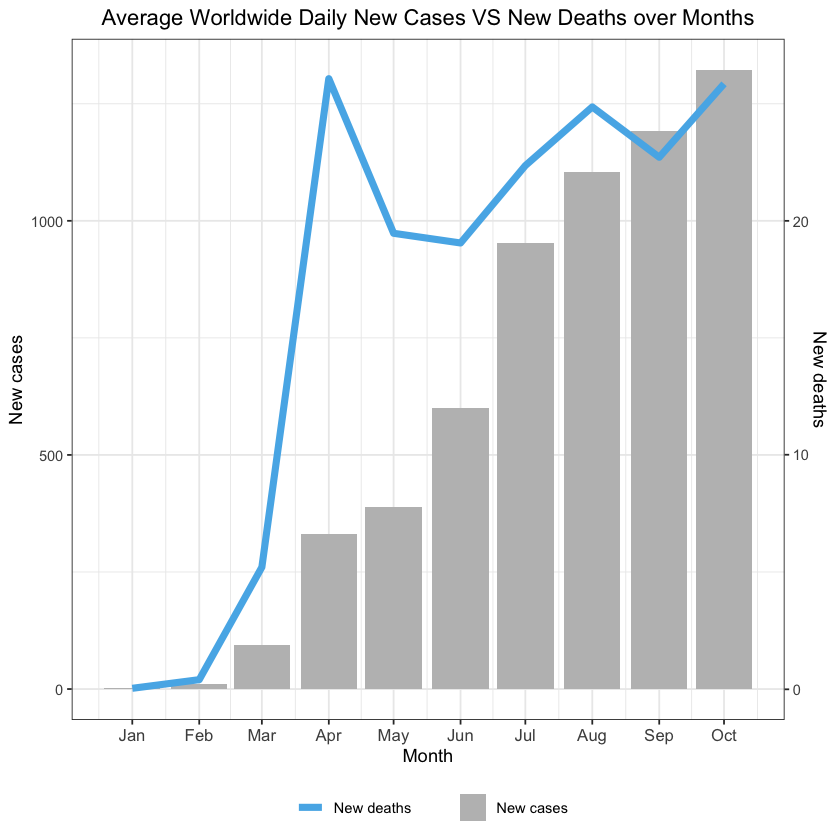

In [976]:
# plot average worldwide daily new cases vs new deaths over months
covid_df %>%
  mutate(yr_mth = as.Date(Date %>% format("%Y-%m-01"))) %>%
  group_by(yr_mth) %>%
  summarise(mean_deaths = mean(New_deaths), mean_cases = mean(New_cases)) %>%
  ggplot() +
  geom_bar(mapping = aes(x = yr_mth, y = mean_cases, fill = "New cases"), stat = "identity") +
  geom_line(mapping = aes(x = yr_mth, y = mean_deaths * 50, color = "New deaths"), size = 2) +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  scale_y_continuous(name = "New cases", 
  sec.axis = sec_axis(~./50, name = "New deaths")) + 
  scale_fill_manual(name = NULL, values = c("New cases" = "grey")) +
  scale_color_manual(name = NULL, values = c("New deaths" = "#56B4E9")) +
  labs(x = "Month") +
  ggtitle("Average Worldwide Daily New Cases VS New Deaths over Months") +
  theme_bw() +
  theme(axis.text.x = element_text(size = 10, angle = 0), 
        legend.position = "bottom",
        plot.title = element_text(hjust = 0.5))

In [1322]:
# filter out cumulated cases value only and ready to plot top 10 countries ranking
covid_cumulatedMonthly <- covid_long %>% 
  filter(Stat == "Cumulative_cases") %>%
  mutate(yr_mth = Date %>% format("%Y-%m")) %>%
  group_by(yr_mth, Country) %>%
  summarise(Value = mean(Value)) %>%
  mutate(Value = Value %>% round(0)) 
covid_cumulatedMonthly %>%
  head()

`summarise()` regrouping output by 'yr_mth' (override with `.groups` argument)



yr_mth,Country,Value
<chr>,<chr>,<dbl>
2020-01,Afghanistan,0
2020-01,Albania,0
2020-01,Algeria,0
2020-01,American Samoa,0
2020-01,Andorra,0
2020-01,Angola,0


In [997]:
# create average daily ranking column and two more columns deal with values and filter out top 10 countries
montly_cumulatedCases = covid_cumulatedMonthly %>% 
  group_by(yr_mth)%>%      
  mutate(rank = rank(-Value),
         Value_rel = Value/Value[rank==1],
         Value_lbl = paste0(" ",Value)) %>%
  group_by(Country) %>%
  filter(rank <= 10)
montly_cumulatedCases %>%
  head()

yr_mth,Country,Value,rank,Value_rel,Value_lbl
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
2020-01,Australia,2,9.0,0.001569859,2
2020-01,China,1274,1.0,1.000000000,1274
2020-01,France,2,9.0,0.001569859,2
2020-01,Japan,3,4.5,0.002354788,3
2020-01,Malaysia,2,9.0,0.001569859,2
2020-01,Nepal,2,9.0,0.001569859,2


In [1003]:
# plot updated top 10 countries with most cumulated Covid-19 cases over months
anim <- montly_cumulatedCases %>%
  ggplot(aes(rank, group = Country))+
  geom_tile(aes(y = Value/2,
                height = Value,
                width = 0.9), alpha = 0.8, color = NA) +
  geom_text(aes(y = 0, label = paste(Country, " ")), vjust = 0.2, hjust = 1, size = 7) + #determine size of the Country label
  geom_text(aes(y=Value,label = Value_lbl, hjust=0),size = 8 ) +  #determine size of the value label
  coord_flip(clip = "off", expand = TRUE) +
  scale_x_reverse() +
  theme_minimal() +
  theme(axis.line=element_blank(),
        axis.text.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks=element_blank(),
        axis.title.x=element_blank(),
        axis.title.y=element_blank(),
        legend.position="none",
        panel.background=element_blank(),
        panel.border=element_blank(),
        panel.grid.major=element_blank(),
        panel.grid.minor=element_blank(),
        panel.grid.major.x = element_line( size=.1, color="grey" ),
        panel.grid.minor.x = element_line( size=.1, color="grey" ),
        plot.title=element_text(size=25, hjust=0.5, face="bold",     colour="red", vjust=-1),
        plot.subtitle=element_text(size=18, hjust=0.5, face="italic", color="red"),
        plot.caption =element_text(size=12, hjust=0.5, face="italic", color="red"),
        plot.background=element_blank(),
        plot.margin = margin(1,4, 1, 8, "cm")) +
  transition_states(yr_mth, transition_length = 4, state_length = 1) +
  ease_aes('sine-in-out') +
  labs(title = 'Top 10 Countries Ranking with Most Cumulated Covid-19 Cases: {closest_state}',  
       caption  = "Data Source: https://covid19.who.int")

In [1004]:
# load png package
library(png)

In [1005]:
# save the animation plot
animate(anim, nframes = 350,fps = 25,  width = 1200, height = 1000, 
        renderer = gifski_renderer("gganim.gif"))


Rendering [--------------------------------------------] at 7.9 fps ~ eta: 44s

Rendering [--------------------------------------------] at 7.3 fps ~ eta: 47s

Rendering [>---------------------------------------------] at 7 fps ~ eta: 49s

Rendering [>-------------------------------------------] at 7.2 fps ~ eta: 48s

Rendering [>-------------------------------------------] at 7.3 fps ~ eta: 47s

Rendering [>-------------------------------------------] at 7.2 fps ~ eta: 48s

Rendering [>-------------------------------------------] at 7.1 fps ~ eta: 48s

Rendering [>---------------------------------------------] at 7 fps ~ eta: 48s

Rendering [>---------------------------------------------] at 7 fps ~ eta: 49s

Rendering [=>------------------------------------------] at 6.9 fps ~ eta: 49s

Rendering [=>--------------------------------------------] at 7 fps ~ eta: 48s

Rendering [=>--------------------------------------------] at 7 fps ~ eta: 47s

Rendering [==>-------------------------


Rendering [===========================>----------------] at 7.3 fps ~ eta: 18s

Rendering [===========================>----------------] at 7.4 fps ~ eta: 17s

Rendering [============================>---------------] at 7.4 fps ~ eta: 17s

Rendering [============================>---------------] at 7.4 fps ~ eta: 16s

Rendering [=============================>--------------] at 7.4 fps ~ eta: 16s

Rendering [=============================>--------------] at 7.4 fps ~ eta: 15s

Rendering [==============================>-------------] at 7.4 fps ~ eta: 14s

Rendering [==============================>-------------] at 7.5 fps ~ eta: 14s

Rendering [==============================>-------------] at 7.5 fps ~ eta: 13s

Rendering [===============================>------------] at 7.5 fps ~ eta: 13s

Rendering [===============================>------------] at 7.5 fps ~ eta: 12s

Rendering [================================>-----------] at 7.5 fps ~ eta: 12s

Rendering [============================

In [35]:
# load population dataset
population_df <- "WPP2019_TotalPopulationBySex.csv" %>%
  read_csv

Parsed with column specification:
cols(
  LocID = col_double(),
  Location = col_character(),
  VarID = col_double(),
  Variant = col_character(),
  Time = col_double(),
  MidPeriod = col_double(),
  PopMale = col_double(),
  PopFemale = col_double(),
  PopTotal = col_double(),
  PopDensity = col_double()
)



In [36]:
# we only need the lastest figures and one row from duplicates, rename with a suitable name
population_df <- population_df %>%
  filter(Variant == "Medium" & Time == 2020) %>%
  rename(Country = Location)

In [37]:
# find out country name with "Other"
population_df %>%
  filter(grepl("Other", Country))

LocID,Country,VarID,Variant,Time,MidPeriod,PopMale,PopFemale,PopTotal,PopDensity
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1674,Land-locked Countries (Others),2,Medium,2020,2020.5,30333.83,32118.97,62452.81,98.906
1827,Western European and Others Group (WEOG),2,Medium,2020,2020.5,455534.21,468187.44,923721.64,29.646


In [38]:
# assign "Other" to the "Other" country
population_df$Country[population_df$Country == "Land-locked Countries (Others)"] <- "Other"

In [39]:
# creat a list with irrelaveant country names
area_list = list("Europe", "Asia", "WHO", "South America", "UNICEF", "WB", "UNFPA", "Oceania", "Group", "Country", 
                 "Union", "Organization", "Caribbean", "Pacific", "Low", "Land", "Countries", "SIDS", "ESCAP", 
                 "ESCWA", "Community", "Latin", "LLDC", "/", "developed", "countries", "League", "BRI", "Western", 
                 "World", "Member", "dependencies", "Eastern", "Organisation", "group", "Common", "Trade", "ECE")

In [40]:
# filter out the irrelaveant rows by match the area list
population_df <- population_df %>%
  filter(!grepl(paste(area_list, collapse = "|"), Country))

In [41]:
# join the covid dataframe with population dataframe with a full join by country names
covid_pop <- covid_df %>%
  full_join(population_df, by = "Country")

In [42]:
# find out the unmatched countries from covid dataframe
data_miss <- covid_pop %>%
  filter(is.na(PopTotal))
data_miss$Country %>% 
  unique() %>%
  sort()

[1] "Côte d’Ivoire"                                           
 [2] "Democratic People's Republic of Korea"                   
 [3] "Guernsey"                                                
 [4] "Jersey"                                                  
 [5] "Kosovo[1]"                                               
 [6] "Micronesia (Federated States of)"                        
 [7] "Northern Mariana Islands (Commonwealth of the)"          
 [8] "Pitcairn Islands"                                        
 [9] "Saint Martin"                                            
[10] "Sint Maarten"                                            
[11] "The United Kingdom"                                      
[12] "Wallis and Futuna"                                       
[13] "occupied Palestinian territory, including east Jerusalem"

In [43]:
# find out the unmatched countries from population dataframe
missing <- covid_pop %>%
    filter(is.na(Cumulative_deaths))
missing$Country %>%
    unique() %>%
    sort()

[1] "Africa"                                                
 [2] "Belt-Road Initiative: Africa"                          
 [3] "Black Sea Economic Cooperation (BSEC)"                 
 [4] "Bolivarian Alliance for the Americas (ALBA)"           
 [5] "Central America"                                       
 [6] "Channel Islands"                                       
 [7] "China, Hong Kong SAR"                                  
 [8] "China, Macao SAR"                                      
 [9] "China, Taiwan Province of China"                       
[10] "Côte d'Ivoire"                                         
[11] "Dem. People's Republic of Korea"                       
[12] "Gulf Cooperation Council (GCC)"                        
[13] "Melanesia"                                             
[14] "Micronesia"                                            
[15] "Micronesia (Fed. States of)"                           
[16] "Middle Africa"                                         
[17] "New EU member states (joined since 2004)"              
[18] "Non-Self-Governing Territories"                        
[19] "Northern Africa"                                       
[20] "Northern America"                                      
[21] "Northern Mariana Islands"                              
[22] "Polynesia"                                             
[23] "Saint Martin (French part)"                            
[24] "Sint Maarten (Dutch part)"                             
[25] "Southern Africa"                                       
[26] "State of Palestine"                                    
[27] "Sub-Saharan Africa"                                    
[28] "United Kingdom"                                        
[29] "United Nations Economic Commission for Africa (UN-ECA)"
[30] "Wallis and Futuna Islands"

In [44]:
# create a function to match them manually
convert <- function(country){
    if (country %in% "Côte d\'Ivoire"){
        country = "Côte d’Ivoire"
    }
    else if (country %in% "Dem. People\'s Republic of Korea"){
        country = "Democratic People\'s Republic of Korea"
    }
    else if (country %in% "United Kingdom"){
        country = "The United Kingdom"
    }
    else if (country %in% "Sint Maarten (Dutch part)"){
        country = "Sint Maarten"
    }
    else if (country %in% "Saint Martin (French part)"){
        country = "Saint Martin"
    }
    else if (country %in% "Micronesia (Fed. States of)"){
        country = "Micronesia (Federated States of)"
    }
    else if (country %in% "Northern Mariana Islands"){
        country = "Northern Mariana Islands (Commonwealth of the)"
    }
    else if (country %in% "Wallis and Futuna Islands"){
        country = "Wallis and Futuna"
    }
    else if (country %in% "China, Hong Kong SAR"){
        country = "China"
    }
    else if (country %in% "China, Macao SAR"){
        country = "China"
    }
    else if (country %in% "China, Taiwan Province of China"){
        country = "China"
    }
    else
        country = country
}
population_df$Country <- sapply(population_df$Country, convert)

In [45]:
# since multiple rows with same country names, we group them together with one country one row with corresponding 
# figures . We can't group population desity with simple calculation, we need to calculate corresponding square km 
# first, then calculate density back by the sum of population and sum of square km, also fixing the comma messed up 
# with decimal problem when we load the dataset into dataframe
population_df <- population_df %>%
  mutate(PopTotal = PopTotal * 1000) %>%
  mutate(PopDensity = PopDensity * 1000) %>%
  mutate(square_km = PopTotal / PopDensity) %>%
  group_by(Country) %>%
  summarise(Pop_total = sum(PopTotal), PopDensity = Pop_total / sum(square_km)) 

`summarise()` ungrouping output (override with `.groups` argument)



In [46]:
head(population_df)

Country,Pop_total,PopDensity
<chr>,<dbl>,<dbl>
Afghanistan,38928341,59627
Africa,1340598113,45216
Albania,2877800,105029
Algeria,43851043,18411
American Samoa,55197,275985
Andorra,77265,164394


In [47]:
# join them again with left join now
covid_pop <- covid_df %>%
  left_join(population_df, by = "Country")

In [48]:
# find out the unmatched country again, whihc are not available from the population dataframe
data_miss <- covid_pop %>%
  filter(is.na(Pop_total))
data_miss$Country %>% 
  unique() %>%
  sort()

[1] "Guernsey"                                                
[2] "Jersey"                                                  
[3] "Kosovo[1]"                                               
[4] "Pitcairn Islands"                                        
[5] "occupied Palestinian territory, including east Jerusalem"

In [49]:
# remove missing values and add a column with cumulated covid cases on population percentage
covid_pop <- covid_pop %>%
  filter(!is.na(Cumulative_deaths)) %>%
  mutate(CumCasePop_percent = Cumulative_cases / Pop_total * 100)

In [50]:
# take a look the dataframe
covid_pop %>%
  head()

Date,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Pop_total,PopDensity,CumCasePop_percent
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-01-03,AF,Afghanistan,Eastern Mediterranean,0,0,0,0,38928341,59627,0
2020-01-04,AF,Afghanistan,Eastern Mediterranean,0,0,0,0,38928341,59627,0
2020-01-05,AF,Afghanistan,Eastern Mediterranean,0,0,0,0,38928341,59627,0
2020-01-06,AF,Afghanistan,Eastern Mediterranean,0,0,0,0,38928341,59627,0
2020-01-07,AF,Afghanistan,Eastern Mediterranean,0,0,0,0,38928341,59627,0
2020-01-08,AF,Afghanistan,Eastern Mediterranean,0,0,0,0,38928341,59627,0


In [51]:
# caculated total population
covid_pop$Pop_total %>% 
  na.omit() %>%
  unique() %>%
  sum()

[1] 7851378933

`summarise()` ungrouping output (override with `.groups` argument)



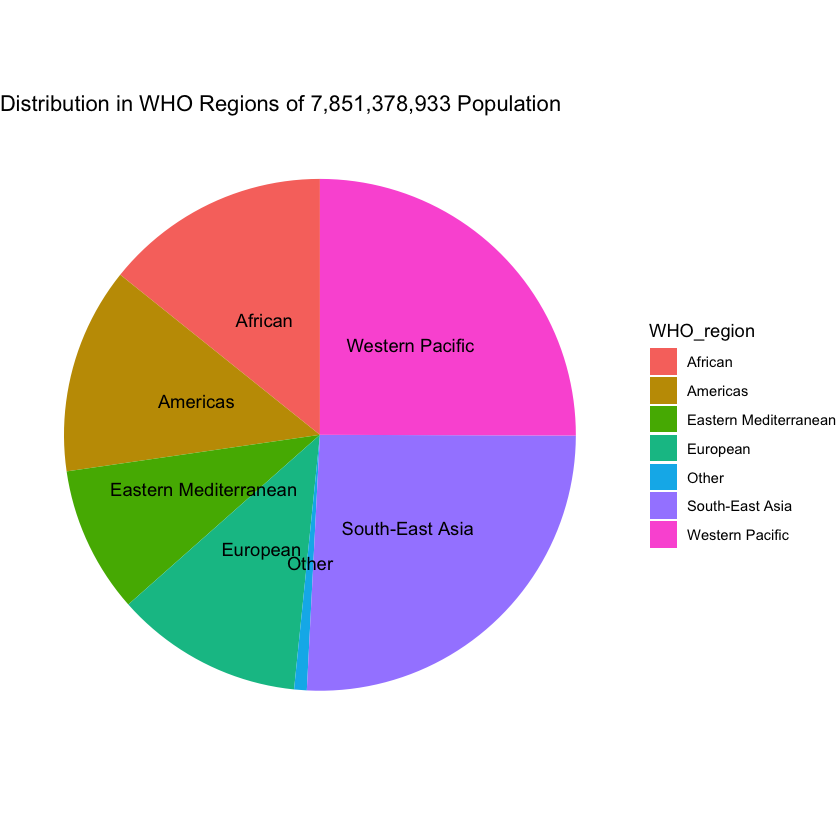

In [52]:
# plot a population distribution in WHO regions
covid_pop %>%
  filter(!is.na(Pop_total)) %>%
  group_by(WHO_region) %>%
  summarise(pop = sum(Pop_total)) %>%
  ggplot(aes(x="", y = pop, fill = WHO_region)) +
  geom_bar(stat = "identity", width = 1) + 
  geom_text(aes(label = WHO_region), position = position_stack(vjust = 0.5)) +
  coord_polar(theta = "y", start = 0) +
  theme_void() +
  labs(title = 'Distribution in WHO Regions of 7,851,378,933 Population')

In [53]:
# find out the top ten countries with most population density
covid_pop1 <- covid_pop %>%
  group_by(Country) %>%
  summarise(WHO_region = WHO_region[1], Pop_total = mean(Pop_total), PopDensity = mean(PopDensity))
covid_pop1[order(covid_pop1$PopDensity, decreasing = TRUE),] %>%
  top_n(10, PopDensity)

`summarise()` ungrouping output (override with `.groups` argument)



Country,WHO_region,Pop_total,PopDensity
<chr>,<chr>,<dbl>,<dbl>
Monaco,European,39244,26338255
Singapore,Western Pacific,5850343,8357633
Gibraltar,European,33691,3369100
Bahrain,Eastern Mediterranean,1701583,2238925
Holy See,European,809,1838636
Maldives,South-East Asia,540542,1801807
Malta,European,441539,1379809
Bangladesh,South-East Asia,164689383,1265187
Sint Maarten,Americas,42882,1261235


Apart from Singapore, other countries are not familiar when we explore Covid-19 dataframe when it became serious.

In [54]:
# find out the top ten countries with most population
covid_pop1[order(covid_pop1$Pop_total, decreasing = TRUE),] %>%
  top_n(10, Pop_total)

Country,WHO_region,Pop_total,PopDensity
<chr>,<chr>,<dbl>,<dbl>
China,Western Pacific,1471286879,156109.8
India,South-East Asia,1380004385,464149.0
United States of America,Americas,331002647,36185.0
Indonesia,South-East Asia,273523621,150987.0
Pakistan,Eastern Mediterranean,220892331,286546.0
Brazil,Americas,212559409,25431.0
Nigeria,African,206139587,226336.0
Bangladesh,South-East Asia,164689383,1265187.0
Russian Federation,European,145934460,8911.0


Now, it is clear that most of these countries are be seen from Covid-19 dataframe. Is population really a matter with Covid-19?

In [55]:
# group by month and country,ready to plot top 10 countries ranking with most cumulated case on population percent
covid_cumulated_percent <- covid_pop %>% 
  mutate(yr_mth = Date %>% format("%Y-%m")) %>%
  group_by(yr_mth, Country) %>%
  summarise(Value = mean(CumCasePop_percent))
covid_cumulated_percent %>%
  head()

`summarise()` regrouping output by 'yr_mth' (override with `.groups` argument)



yr_mth,Country,Value
<chr>,<chr>,<dbl>
2020-01,Afghanistan,0
2020-01,Albania,0
2020-01,Algeria,0
2020-01,American Samoa,0
2020-01,Andorra,0
2020-01,Angola,0


In [56]:
# create average daily ranking column and two more columns deal with values and filter out top 10 countries
montly_cumulatedPercent = covid_cumulated_percent %>% 
  group_by(yr_mth)%>%      
  mutate(rank = rank(-Value),
         Value_rel = Value/Value[rank==1],
         Value_lbl = paste0(" ",Value)) %>%
  group_by(Country) %>%
  filter(rank <= 10)
montly_cumulatedPercent %>%
  head()

yr_mth,Country,Value,rank,Value_rel,Value_lbl
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
2020-01,Australia,9.465899e-06,3,0.10931162,9.46589948183788e-06
2020-01,Cambodia,5.156232e-06,9,0.05954385,5.15623219585249e-06
2020-01,China,8.659555e-05,1,1.00000000,8.65955500386979e-05
2020-01,Malaysia,7.031645e-06,6,0.08120100,7.03164496569986e-06
2020-01,Nepal,5.325649e-06,8,0.06150026,5.32564904821089e-06
2020-01,Republic of Korea,6.255018e-06,7,0.07223256,6.25501785687542e-06


In [1053]:
# plot updated top 10 countries with most cumulated Covid-19 cases percentage on population over months
anim_percent <- montly_cumulatedPercent %>%
  ggplot(aes(rank, group = Country))+
  geom_tile(aes(y = Value/2,
                height = Value,
                width = 0.9), alpha = 0.8, color = NA) +
  geom_text(aes(y = 0, label = paste(Country, " ")), vjust = 0.2, hjust = 1, size = 7) + #determine size of the Country label
  geom_text(aes(y=Value,label = Value_lbl, hjust=0),size = 8 ) +  #determine size of the value label
  coord_flip(clip = "off", expand = TRUE) +
  scale_x_reverse() +
  theme_minimal() +
  theme(axis.line=element_blank(),
        axis.text.x=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks=element_blank(),
        axis.title.x=element_blank(),
        axis.title.y=element_blank(),
        legend.position="none",
        panel.background=element_blank(),
        panel.border=element_blank(),
        panel.grid.major=element_blank(),
        panel.grid.minor=element_blank(),
        panel.grid.major.x = element_line( size=.1, color="grey" ),
        panel.grid.minor.x = element_line( size=.1, color="grey" ),
        plot.title=element_text(size=25, hjust=0.5, face="bold",     colour="red", vjust=-1),
        plot.subtitle=element_text(size=18, hjust=0.5, face="italic", color="red"),
        plot.caption =element_text(size=12, hjust=0.5, face="italic", color="red"),
        plot.background=element_blank(),
        plot.margin = margin(1,4, 1, 8, "cm")) +
  transition_states(yr_mth, transition_length = 4, state_length = 1) +
  ease_aes('sine-in-out') +
  labs(title = 'Top 10 Countries Ranking with Most Cumulated Covid-19 Cases Percentage on Population : {closest_state}',  
       caption  = "Data Source: https://covid19.who.int")

In [1054]:
# save the animation plot
animate(anim_percent, nframes = 350,fps = 25,  width = 1200, height = 1000, 
        renderer = gifski_renderer("gganim_percent.gif"))


Rendering [--------------------------------------------] at 7.1 fps ~ eta: 49s

Rendering [--------------------------------------------] at 6.7 fps ~ eta:  1m

Rendering [>-------------------------------------------] at 6.5 fps ~ eta:  1m

Rendering [>-------------------------------------------] at 6.4 fps ~ eta:  1m

Rendering [>-------------------------------------------] at 6.5 fps ~ eta:  1m

Rendering [>-------------------------------------------] at 6.4 fps ~ eta:  1m

Rendering [=>------------------------------------------] at 6.3 fps ~ eta:  1m

Rendering [=>------------------------------------------] at 6.2 fps ~ eta:  1m

Rendering [=>------------------------------------------] at 6.1 fps ~ eta:  1m

Rendering [==>-----------------------------------------] at 6.1 fps ~ eta:  1m

Rendering [==>-----------------------------------------] at 6.2 fps ~ eta:  1m

Rendering [==>-----------------------------------------] at 6.1 fps ~ eta:  1m

Rendering [==>-------------------------


Rendering [================================>-----------] at 6.2 fps ~ eta: 15s

Rendering [================================>-----------] at 6.2 fps ~ eta: 14s

Rendering [=================================>----------] at 6.2 fps ~ eta: 13s

Rendering [=================================>----------] at 6.2 fps ~ eta: 12s

Rendering [==================================>---------] at 6.2 fps ~ eta: 12s

Rendering [==================================>---------] at 6.3 fps ~ eta: 12s

Rendering [==================================>---------] at 6.3 fps ~ eta: 11s

Rendering [===================================>--------] at 6.3 fps ~ eta: 11s

Rendering [===================================>--------] at 6.3 fps ~ eta: 10s

Rendering [===================================>--------] at 6.3 fps ~ eta:  9s

Rendering [====================================>-------] at 6.3 fps ~ eta:  9s

Rendering [====================================>-------] at 6.4 fps ~ eta:  9s

Rendering [============================

In [57]:
# load education open status dataset into a dataframe
edu_ins_status <- "covid_impact_education.csv" %>% 
    read_csv()

Parsed with column specification:
cols(
  Date = col_character(),
  ISO = col_character(),
  Country = col_character(),
  Status = col_character(),
  Note = col_logical()
)

Warning message:
“85 parsing failures.
  row  col           expected                                                                              actual                         file
41588 Note 1/0/T/F/TRUE/FALSE only 2.4% educational establishments in Argentina have opened face-to-face learning 'covid_impact_education.csv'
41798 Note 1/0/T/F/TRUE/FALSE only 2.4% educational establishments in Argentina have opened face-to-face learning 'covid_impact_education.csv'
42008 Note 1/0/T/F/TRUE/FALSE only 2.4% educational establishments in Argentina have opened face-to-face learning 'covid_impact_education.csv'
42218 Note 1/0/T/F/TRUE/FALSE only 2.4% educational establishments in Argentina have opened face-to-face learning 'covid_impact_education.csv'
42428 Note 1/0/T/F/TRUE/FALSE only 2.4% educational establishments in Ar

In [58]:
# convert the date column into a correct data type
edu_ins_status$Date = as.Date(edu_ins_status$Date, format = "%d/%m/%Y")

In [59]:
# remove the irrelevant column
edu_ins_status <- edu_ins_status[-5]

In [60]:
# take a look the dataframe
edu_ins_status %>%
  head()

Date,ISO,Country,Status
<date>,<chr>,<chr>,<chr>
2020-02-16,ABW,Aruba,Fully open
2020-02-16,AFG,Afghanistan,Fully open
2020-02-16,AGO,Angola,Fully open
2020-02-16,AIA,Anguilla,Fully open
2020-02-16,ALB,Albania,Fully open
2020-02-16,AND,Andorra,Fully open


In [61]:
# find out how many days and countries are covered in the dataframe
edu_ins_status$Date %>% unique() %>% length()
edu_ins_status$Country %>% unique() %>% length()

[1] 259

[1] 210

In [62]:
# join the covid dataframe with education open status dataframe with a left join on data and country
covid_pop_edu <- covid_pop %>%
  left_join(edu_ins_status, by = c("Date", "Country"), copy = TRUE)

In [64]:
write.csv(covid_pop_edu, "Covid_pop_edu.csv")

In [65]:
# remove rows with missing open status value
edu_impact <- covid_pop_edu %>%
  filter(!is.na(Status))
edu_impact %>%
  head()

Date,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Pop_total,PopDensity,CumCasePop_percent,ISO,Status
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
2020-02-16,AF,Afghanistan,Eastern Mediterranean,0,0,0,0,38928341,59627,0,AFG,Fully open
2020-02-17,AF,Afghanistan,Eastern Mediterranean,0,0,0,0,38928341,59627,0,AFG,Fully open
2020-02-18,AF,Afghanistan,Eastern Mediterranean,0,0,0,0,38928341,59627,0,AFG,Fully open
2020-02-19,AF,Afghanistan,Eastern Mediterranean,0,0,0,0,38928341,59627,0,AFG,Fully open
2020-02-20,AF,Afghanistan,Eastern Mediterranean,0,0,0,0,38928341,59627,0,AFG,Fully open
2020-02-21,AF,Afghanistan,Eastern Mediterranean,0,0,0,0,38928341,59627,0,AFG,Fully open


In [66]:
# overview the dataframe
edu_impact %>%
  str()

tibble [46,700 × 13] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Date              : Date[1:46700], format: "2020-02-16" "2020-02-17" ...
 $ Country_code      : chr [1:46700] "AF" "AF" "AF" "AF" ...
 $ Country           : chr [1:46700] "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ WHO_region        : chr [1:46700] "Eastern Mediterranean" "Eastern Mediterranean" "Eastern Mediterranean" "Eastern Mediterranean" ...
 $ New_cases         : num [1:46700] 0 0 0 0 0 0 0 0 5 0 ...
 $ Cumulative_cases  : num [1:46700] 0 0 0 0 0 0 0 0 5 5 ...
 $ New_deaths        : num [1:46700] 0 0 0 0 0 0 0 0 0 0 ...
 $ Cumulative_deaths : num [1:46700] 0 0 0 0 0 0 0 0 0 0 ...
 $ Pop_total         : num [1:46700] 38928341 38928341 38928341 38928341 38928341 ...
 $ PopDensity        : num [1:46700] 59627 59627 59627 59627 59627 ...
 $ CumCasePop_percent: num [1:46700] 0 0 0 0 0 ...
 $ ISO               : chr [1:46700] "AFG" "AFG" "AFG" "AFG" ...
 $ Status            : chr [1:46700] "Fully open" "

In [67]:
# find out the what the open status are
edu_impact$Status %>% unique()

[1] "Fully open"             "Partially open"         "Closed due to COVID-19"
[4] "Academic break"

Saving 7 x 7 in image



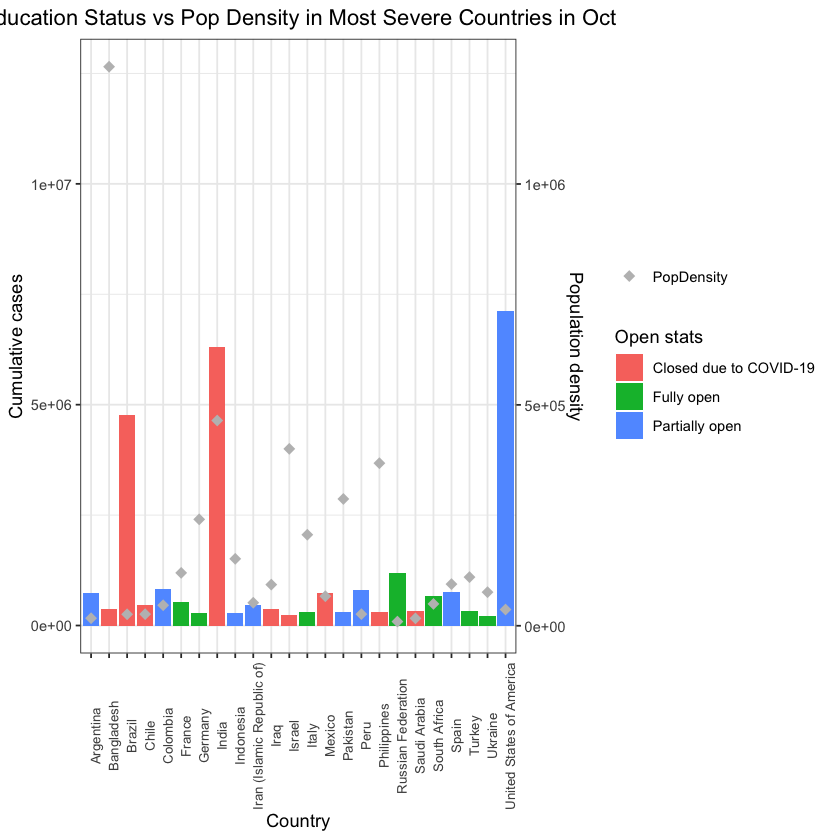

In [68]:
# plot the most severe countries with their education open status on 1st of Oct and corresponding population density
edu_impact %>%
  filter(Date == "2020-10-01" & Cumulative_cases >= 200000) %>%
  ggplot() +
  geom_bar(mapping = aes(x = Country, y = Cumulative_cases, fill = Status), position="dodge", stat = "identity") +
  geom_point(mapping = aes(x = Country, y = PopDensity*10, color = "PopDensity"), size = 3, shape = "diamond") +
  scale_y_continuous(name = "Cumulative cases", 
  sec.axis = sec_axis(~./10, name = "Population density")) +
  guides(fill=guide_legend(title="Open stats")) +
  scale_color_manual(name = NULL, values = c("PopDensity" = "grey")) +
  ggtitle("Education Status vs Pop Density in Most Severe Countries in Oct") +
  theme_bw() +
  theme(axis.text.x = element_text(size = 8, angle = 90), plot.title = element_text(hjust = 0.5)) +
  ggsave("edu_impact1.png")

United States still partially open might due to a relative low population density, rather than India, which is closed with a higher population density figure. Russian is still open and has a relative low population density.

Saving 7 x 7 in image



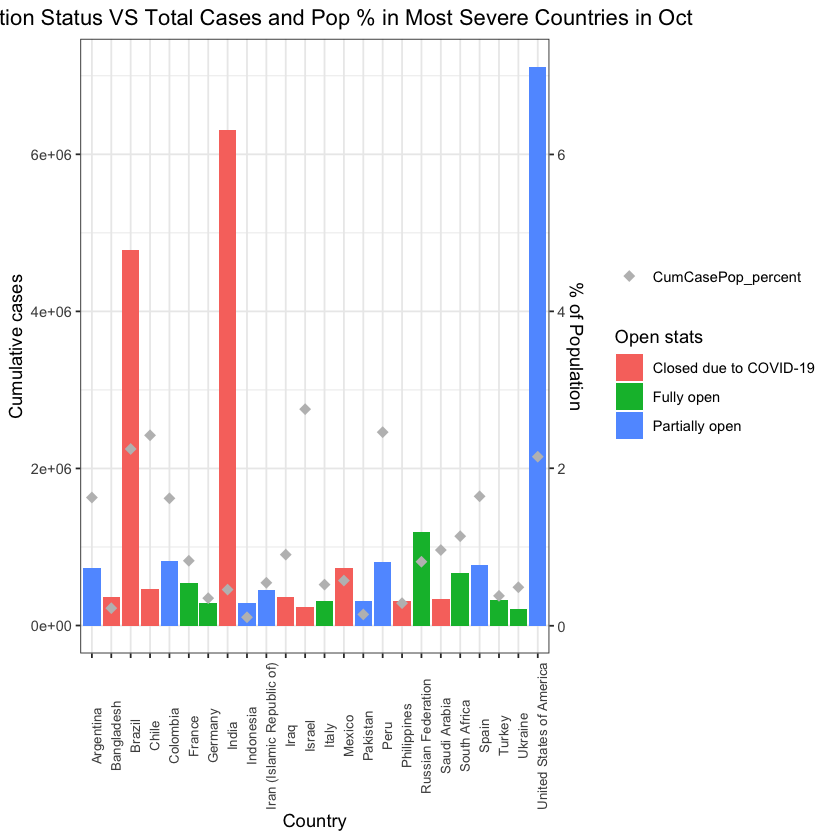

In [71]:
# plot the most severe countries with their education open status on 1st of Oct and corresponding cumulated covid 
# cases and population percentage
edu_impact %>%
  filter(Date == "2020-10-01" & Cumulative_cases >= 200000) %>%
  ggplot() +
  geom_bar(mapping = aes(x = Country, y = Cumulative_cases, fill = Status), position="dodge", stat = "identity") +
  geom_point(mapping = aes(x = Country, y = CumCasePop_percent*1000000, color = "CumCasePop_percent"), size = 3, shape = "diamond") +
  scale_y_continuous(name = "Cumulative cases", 
  sec.axis = sec_axis(~./1000000, name = "% of Population")) +
  guides(fill=guide_legend(title="Open stats")) +
  scale_color_manual(name = NULL, values = c("CumCasePop_percent" = "grey")) +
  ggtitle("Education Status VS Total Cases and Pop % in Most Severe Countries in Oct") +
  theme_bw() +
  theme(axis.text.x = element_text(size = 8, angle = 90), plot.title = element_text(hjust = 0.5)) +
  ggsave("edu_impact.png")

Brasil closed it's schools might due to relative high percentage on cumulated cases over population, rather than it's population density.

In [73]:
# convert the dataframe with monthly average
edu_impact_monthly <- edu_impact %>%
  mutate(yr_mnth = Date %>% format("%Y-%m")) %>%
  group_by(yr_mnth, Country) %>% 
  summarise(Country_code = Country_code[1], WHO_region = WHO_region[1], Cumulative_monthlyCases = sum(New_cases), 
            Cumulative_cases = Cumulative_cases[1], Cumulative_monthlyDeath = sum(New_deaths), Cumulative_deaths = Cumulative_deaths[1],
           ISO = ISO[1], Status = Status[1], Pop_total = mean(Pop_total), PopDensity = mean(PopDensity), CumCasePop_percent = mean(CumCasePop_percent))

`summarise()` regrouping output by 'yr_mnth' (override with `.groups` argument)



In [74]:
# take a look the dataframe
edu_impact_monthly %>%
  head()

yr_mnth,Country,Country_code,WHO_region,Cumulative_monthlyCases,Cumulative_cases,Cumulative_monthlyDeath,Cumulative_deaths,ISO,Status,Pop_total,PopDensity,CumCasePop_percent
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2020-02,Afghanistan,AF,Eastern Mediterranean,5,0,0,0,AFG,Fully open,38928341,59627,5.504620e-06
2020-02,Albania,AL,European,0,0,0,0,ALB,Fully open,2877800,105029,0.000000e+00
2020-02,Algeria,DZ,African,5,0,0,0,DZA,Fully open,43851043,18411,4.072228e-06
2020-02,Andorra,AD,European,0,0,0,0,AND,Fully open,77265,164394,0.000000e+00
2020-02,Angola,AO,African,0,0,0,0,AGO,Fully open,32866268,26363,0.000000e+00
2020-02,Anguilla,AI,Americas,0,0,0,0,AIA,Fully open,15002,166689,0.000000e+00


`summarise()` regrouping output by 'WHO_region' (override with `.groups` argument)



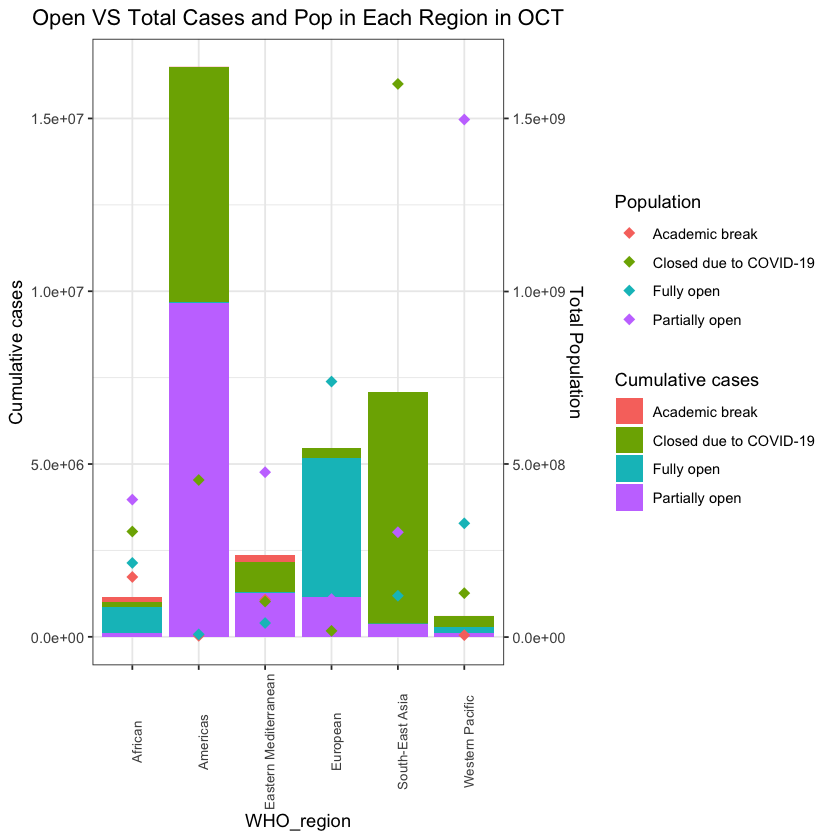

In [75]:
# plot education status vs cumulated covid cases and total population in each WHO region in OCT
edu_impact_monthly %>%
  filter(yr_mnth == "2020-10") %>%
  group_by(WHO_region, Status) %>%
  summarise(Cumulative_cases = sum(Cumulative_cases), Pop = sum(Pop_total)) %>%
  ggplot() +
  geom_bar(mapping = aes(x = WHO_region, y = Cumulative_cases, fill = Status), position="stack", stat = "identity") +
  geom_point(mapping = aes(x = WHO_region, y = Pop/100, color = Status), size = 3, shape = "diamond") +
  scale_y_continuous(name = "Cumulative cases", 
  sec.axis = sec_axis(~.*100, name = "Total Population")) +
  guides(fill=guide_legend(title="Cumulative cases")) +
  guides(color=guide_legend(title="Population")) +
  ggtitle("Open VS Total Cases and Pop in Each Region in OCT") +
  theme_bw() +
  theme(axis.text.x = element_text(size = 8, angle = 90), plot.title = element_text(hjust = 0.5))

Different region, different attitudes towards education openning status.

In [76]:
# load required packages to plot world maps
library(dplyr)
library(maps)
library(viridis)
theme_set(theme_bw())


Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map


Loading required package: viridisLite



In [77]:
# read world map
world_map <- map_data("world")

In [78]:
# add a region column to match with world map's column
data_map <- edu_impact_monthly %>%
  mutate(region = Country)

In [79]:
# do a full join with the covid dataframe and world map data
data_worldmap <- full_join(data_map, world_map, by = "region")

In [80]:
# find out unmatched countries from covid dataframe
data_miss <- data_worldmap %>%
  filter(is.na(long))
data_miss$region %>% 
  unique() %>%
  sort()

[1] "Antigua and Barbuda"                  
 [2] "Bolivia (Plurinational State of)"     
 [3] "British Virgin Islands"               
 [4] "Brunei Darussalam"                    
 [5] "Cabo Verde"                           
 [6] "Congo"                                
 [7] "Curaçao"                              
 [8] "Czechia"                              
 [9] "Democratic People's Republic of Korea"
[10] "Eswatini"                             
[11] "Gibraltar"                            
[12] "Iran (Islamic Republic of)"           
[13] "Micronesia (Federated States of)"     
[14] "North Macedonia"                      
[15] "Republic of Korea"                    
[16] "Republic of Moldova"                  
[17] "Russian Federation"                   
[18] "Saint Kitts and Nevis"                
[19] "Saint Vincent and the Grenadines"     
[20] "Syrian Arab Republic"                 
[21] "Tokelau"                              
[22] "Trinidad and Tobago"                  
[23] "Tuvalu"                               
[24] "United Republic of Tanzania"          
[25] "United States of America"             
[26] "Viet Nam"

In [81]:
# find out unmatched countries from world map dataframe
missing <- data_worldmap %>%
    filter(is.na(Country))
missing$region %>%
    unique() %>%
    sort()

[1] "American Samoa"                      "Antarctica"                         
 [3] "Antigua"                             "Ascension Island"                   
 [5] "Azores"                              "Barbuda"                            
 [7] "Bolivia"                             "Bonaire"                            
 [9] "Brunei"                              "Canary Islands"                     
[11] "Cape Verde"                          "Central African Republic"           
[13] "Chagos Archipelago"                  "Christmas Island"                   
[15] "Cocos Islands"                       "Curacao"                            
[17] "Czech Republic"                      "Falkland Islands"                   
[19] "French Guiana"                       "French Polynesia"                   
[21] "French Southern and Antarctic Lands" "Grenadines"                         
[23] "Guadeloupe"                          "Guam"                               
[25] "Guernsey"                            "Heard Island"                       
[27] "Iran"                                "Isle of Man"                        
[29] "Ivory Coast"                         "Jersey"                             
[31] "Kosovo"                              "Laos"                               
[33] "Macedonia"                           "Madeira Islands"                    
[35] "Martinique"                          "Mayotte"                            
[37] "Micronesia"                          "Moldova"                            
[39] "Nevis"                               "New Caledonia"                      
[41] "Norfolk Island"                      "North Korea"                        
[43] "Northern Mariana Islands"            "Palestine"                          
[45] "Pitcairn Islands"                    "Puerto Rico"                        
[47] "Republic of Congo"                   "Reunion"                            
[49] "Russia"                              "Saba"                               
[51] "Saint Barthelemy"                    "Saint Helena"                       
[53] "Saint Kitts"                         "Saint Martin"                       
[55] "Saint Pierre and Miquelon"           "Saint Vincent"                      
[57] "Sao Tome and Principe"               "Siachen Glacier"                    
[59] "Sint Eustatius"                      "Sint Maarten"                       
[61] "South Georgia"                       "South Korea"                        
[63] "South Sandwich Islands"              "Swaziland"                          
[65] "Syria"                               "Taiwan"                             
[67] "Tanzania"                            "Tobago"                             
[69] "Trinidad"                            "Turks and Caicos Islands"           
[71] "UK"                                  "USA"                                
[73] "Vatican"                             "Venezuela"                          
[75] "Vietnam"                             "Virgin Islands"                     
[77] "Wallis and Futuna"                   "Western Sahara"

In [82]:
# create a function to match them manually
convert <- function(country){
    if (country %in% "Antigua"){
        country = "Antigua and Barbuda"
    }
    else if (country %in% "Barbuda"){
        country = "Antigua and Barbuda"
    }
    else if (country %in% "Virgin Islands"){
        country = "British Virgin Islands"
    }
    else if (country %in% "Bolivia"){
        country = "Bolivia (Plurinational State of)"
    }
    else if (country %in% "Brunei"){
        country = "Brunei Darussalam"
    }
    else if (country %in% "Cape Verde"){
        country = "Cabo Verde"
    }
    else if (country %in% "Curacao"){
        country = "Curaçao"
    }
    else if (country %in% "Czech Republic"){
        country = "Czechia"
    }
    else if (country %in% "North Korea"){
        country = "Democratic People\'s Republic of Korea"
    }
    else if (country %in% "Swaziland"){
        country = "Eswatini"
    }
    else if (country %in% "Republic of Congo"){
        country = "Congo"
    }
    else if (country %in% "USA"){
        country = "United States of America"
    }
    else if (country %in% "Iran"){
        country = "Iran (Islamic Republic of)"
    }
    else if (country %in% "Micronesia"){
        country = "Micronesia (Federated States of)"
    }
    else if (country %in% "Macedonia"){
        country = "North Macedonia"
    }
    else if (country %in% "South Korea"){
        country = "Republic of Korea"
    }
    else if (country %in% "Moldova"){
        country = "Republic of Moldova"
    }
    else if (country %in% "Russia"){
        country = "Russian Federation"
    }
    else if (country %in% "Saint Kitts"){
        country = "Saint Kitts and Nevis"
    }
    else if (country %in% "Nevis"){
        country = "Saint Kitts and Nevis"
    }
    else if (country %in% "Saint Vincent"){
        country = "Saint Vincent and the Grenadines"
    }
    else if (country %in% "Grenadines"){
        country = "Saint Vincent and the Grenadines"
    }
    else if (country %in% "Syria"){
        country = "Syrian Arab Republic"
    }
    else if (country %in% "Trinidad"){
        country = "Trinidad and Tobago"
    }
    else if (country %in% "Tobago"){
        country = "Trinidad and Tobago"
    }
    else if (country %in% "Vietnam"){
        country = "Viet Nam"
    }
    else if (country %in% "Tanzania"){
        country = "United Republic of Tanzania"
    }
    else if (country %in% "Taiwan"){
        country = "China"
    }
    else country = country
}

world_map$region <- sapply(world_map$region, convert)

In [83]:
# do a join again with left join this time
data_worldmap <- full_join(data_map, world_map, by = "region")

In [84]:
# find out the countries still can't be matched with world map, however, they are not available from world map
data_miss <- data_worldmap %>%
  filter(is.na(long))
data_miss$region %>% 
  unique() %>%
  sort()

[1] "Gibraltar" "Tokelau"   "Tuvalu"

In [1238]:
# animated world map with cumulated cases over time
map_cum <- data_worldmap %>%
  ggplot(aes(long, lat, group = group)) +
  geom_polygon(aes(fill = Cumulative_cases), color = NA) +
  scale_fill_viridis_c(option = "C", trans = "log") +
  theme(plot.margin = margin(2,.5,7,.5, "cm"),
        plot.title=element_text(size=25, hjust=0.5, face="bold", colour="#56B4E9", vjust=-1),
        plot.background = element_rect(fill = "transparent", colour = NA),  
        panel.border = element_blank(), 
        panel.background = element_rect(fill = "transparent", colour = NA),
        panel.grid = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  labs(x="", y="") +
  transition_manual(yr_mnth) +
  ease_aes('sine-in-out') +
  ggtitle("Cumulated Covid-19 Cases in: {current_frame}") 

In [1239]:
# save the animation file
animate(map_cum, nframes = 350,fps = 25,  width = 1200, height = 1000, 
        renderer = gifski_renderer("worldmap_cum.gif"))

Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message in lapply(row_vars$frames, as.integer):
“NAs introduced by coercion”
Warning message in split.default(x = seq_len(nrow(x)), f = f, drop = drop, ...):
“NAs introduced by coercion”
nframes and fps adjusted to match transition


Rendering [====>---------------------------------------] at 1.3 fps ~ eta:  6s

Rendering [=========>----------------------------------] at 1.1 fps ~ eta:  6s

Rendering [==============>-----------------------------] at 1.2 fps ~ eta:  5s

Rendering [===================>------------------------] at 1.3 fps ~ eta:  4s

Rendering [=======================>--------------------] at 1.4 fps ~ eta:  3s

Rendering [============================>---------------] at 1.4 fps ~ eta:  2s

Rendering [=================================>----------] at 1.5 fps ~ eta:  1s

Rendering [======================================>-----] at 1.5 fps ~ eta:  1s

Rendering [===========================

In [1242]:
# animated world map with monthly new cases over time
map_new <- data_worldmap %>%
  ggplot(aes(long, lat, group = group)) +
  geom_polygon(aes(fill = Cumulative_monthlyCases), color = NA) +
  scale_fill_viridis_c(option = "C", trans = "log") +
  theme(plot.margin = margin(2,.5,7,.5, "cm"),
        plot.title=element_text(size=25, hjust=0.5, face="bold", colour="#56B4E9", vjust=-1),
        plot.background = element_rect(fill = "transparent", colour = NA),  
        panel.border = element_blank(), 
        panel.background = element_rect(fill = "transparent", colour = NA),
        panel.grid = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  labs(x="", y="") +
  transition_manual(yr_mnth) +
  ease_aes('sine-in-out') +
  ggtitle("Monthly New Covid-19 Cases in: {current_frame}") 

In [1243]:
# save the animation file
animate(map_new, nframes = 350,fps = 25,  width = 1200, height = 1000, 
        renderer = gifski_renderer("worldmap_new.gif"))

Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message in lapply(row_vars$frames, as.integer):
“NAs introduced by coercion”
Warning message in split.default(x = seq_len(nrow(x)), f = f, drop = drop, ...):
“NAs introduced by coercion”
nframes and fps adjusted to match transition


Rendering [====>---------------------------------------] at 1.8 fps ~ eta:  5s

Rendering [=========>----------------------------------] at 1.7 fps ~ eta:  4s

Rendering [==============>-----------------------------] at 1.8 fps ~ eta:  3s

Rendering [===================>------------------------] at 1.8 fps ~ eta:  3s

Rendering [=======================>--------------------] at 1.8 fps ~ eta:  2s

Rendering [============================>---------------] at 1.8 fps ~ eta:  2s

Rendering [=================================>----------] at 1.8 fps ~ eta:  1s

Rendering [======================================>-----] at 1.8 fps ~ eta:  1s

Rendering [===========================

In [87]:
# animated world map with education status over time
map_edu <- data_worldmap %>%
  ggplot(aes(long, lat, group = group)) +
  scale_fill_viridis(discrete = TRUE, option = "D") +
  geom_polygon(aes(fill = Status)) +
  theme(plot.margin = margin(2,.5,5,.5, "cm"),
        plot.title=element_text(size=25, hjust=0.5, face="bold", colour="#56B4E9", vjust=-1), 
        plot.background = element_rect(fill = "transparent", colour = NA), 
        legend.position = "bottom", 
        panel.border = element_blank(), 
        panel.background = element_rect(fill = "transparent", colour = NA),
        panel.grid = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  labs(x="", y="") +
  transition_manual(yr_mnth) +
  ease_aes('sine-in-out') +
  ggtitle("Education opening status in: {current_frame}") 

In [1296]:
# save the animation file
animate(map_edu, nframes = 350,fps = 25,  width = 1200, height = 1000, 
        renderer = gifski_renderer("worldmap_edu.gif"))

Warning message in lapply(row_vars$frames, as.integer):
“NAs introduced by coercion”
Warning message in split.default(x = seq_len(nrow(x)), f = f, drop = drop, ...):
“NAs introduced by coercion”
nframes and fps adjusted to match transition


Rendering [====>---------------------------------------] at 1.1 fps ~ eta:  7s

Rendering [=========>----------------------------------] at 1.1 fps ~ eta:  7s

Rendering [=============>-----------------------------] at 0.96 fps ~ eta:  6s

Rendering [===================>--------------------------] at 1 fps ~ eta:  5s

Rendering [=========================>--------------------] at 1 fps ~ eta:  4s

Rendering [============================>--------------] at 0.97 fps ~ eta:  3s

Rendering [================================>----------] at 0.98 fps ~ eta:  2s

Rendering [========================================>-----] at 1 fps ~ eta:  1s

Rendering [==============================================] at 1 fps ~ eta:  0s
                                       

Education opening status are mianly open in January and Febuary, and largely colosed due to Covid-19 in March, some of them partially open again in April. For June and July, most of them are having a academic break. After that, almost half and half closed due to Covid-19 and half partialy open. In October, most of them are partially open.